In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data.attribute import YEAR_ATTR, IS_PERMANENT_RESIDENT_ATTR, IS_CITIZEN_ATTR, AGE_ATTR, POPULATION_ATTR, SEX_ATTR, \
    COMMUNE_SIZE_ATTR, COMMUNE_ATTR, COMMUNE_SIZE_LABEL_MAPPER, SEX_LABEL_MAPPER

In [2]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [3]:
year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year]
population_year_df = population_df[(population_df[YEAR_ATTR] == year) & (population_df[IS_PERMANENT_RESIDENT_ATTR])]
electorate_year_df = population_year_df[(population_year_df[IS_CITIZEN_ATTR]) & (population_year_df[AGE_ATTR] >= 18)]

year

np.uint16(2019)

In [31]:
def merge_proportional(distribution: pd.Series, *distributions: tuple[pd.Series, ...]) -> pd.DataFrame:
    distributions = [distribution] + list(distributions)
    return pd.concat([d / d.sum() for d in distributions], axis=1)


def calculate_tvd(distribution: pd.DataFrame, reference: str) -> pd.Series:
    """
    Calculate Total Variation Distance between each column and a reference column.

    Args:
        distribution: DataFrame with probability distributions in columns
        reference: Name of the reference column to compare against

    Returns:
        Series with TVD values for each non-reference column
    """
    return pd.Series({
        column: (0.5 * (distribution[column] - distribution[reference]).abs().sum())
        for column in distribution.columns if column != reference
    })

<Axes: xlabel='Age'>

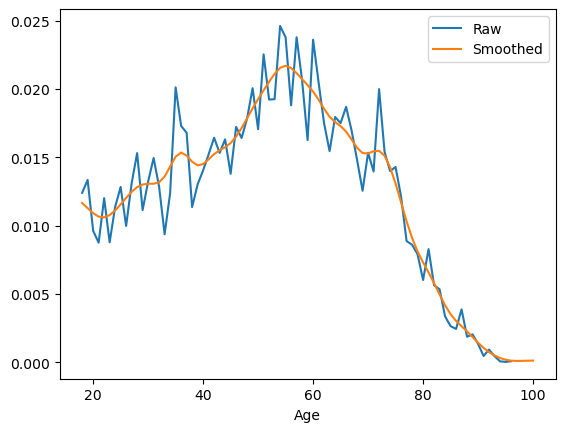

In [5]:
AGE_WEIGHT = 'weight_age'


def apply_age_smoothing(
        df: pd.DataFrame,
        age_std: float = 2,
        min_age: int = 18,
        max_age: int = 100,
        ref_weight: str = 'weightc',
        kernel_size_std: float = 4,
) -> pd.DataFrame:
    """
    Smooth the age distribution in three steps:

    1. Build a target smoothed age histogram using `ref_weight`.
    2. Duplicate and spread each respondent to neighboring ages.
    3. Scale each age-bin to match the target smoothed histogram.

    All other weight columns are adjusted accordingly.
    """
    #
    kernel_radius = int(np.ceil(kernel_size_std * age_std))

    # --- Step 1: Target smoothed age histogram ---
    # Aggregate the reference weight by age.
    agg = df.groupby(AGE_ATTR)[ref_weight].sum()
    all_ages = np.arange(min_age, max_age + 1)
    agg = agg.reindex(all_ages, fill_value=0)

    # Use pandas' rolling with a Gaussian window to smooth the histogram.
    target_distribution = agg.rolling(
        window=2 * kernel_radius + 1,
        win_type='gaussian', center=True, min_periods=1
    ).mean(std=age_std)

    # --- Step 2: Duplicate respondents with candidate weights ---
    # Offsets and raw Gaussian weights for candidates.
    offsets = np.arange(-kernel_radius, kernel_radius + 1)
    kernel = np.exp(-0.5 * (offsets / age_std) ** 2)

    # Create candidate ages and corresponding weights.
    candidate_ages = df[AGE_ATTR].values[:, None] + offsets  # shape: (n, n_offsets)
    candidate_weights = np.tile(kernel, (len(df), 1))

    # Duplicate the DataFrame for each offset.
    duplicated_df = df.loc[df.index.repeat(len(offsets))].copy()
    duplicated_df[AGE_ATTR] = candidate_ages.flatten()
    duplicated_df[AGE_WEIGHT] = candidate_weights.flatten()

    # Keep only candidates within the allowed age range.
    valid = (duplicated_df[AGE_ATTR] >= min_age) & (duplicated_df[AGE_ATTR] <= max_age)
    duplicated_df = duplicated_df[valid].copy().reset_index(drop=True)

    # --- Step 3: Scale candidate weights to match the target histogram ---
    # Total candidate weight per age bin.
    candidate_sum = (duplicated_df[ref_weight] * duplicated_df[AGE_WEIGHT]) \
        .groupby(duplicated_df[AGE_ATTR]).transform('sum')
    # Scale candidate age weight to match the target distribution.
    duplicated_df[AGE_WEIGHT] *= (duplicated_df[AGE_ATTR].map(target_distribution) / candidate_sum).fillna(0)

    # Update all weight columns.
    for col in ('weightc', 'weightst', 'weightp', 'weighttot'):
        duplicated_df[col] = duplicated_df[col] * duplicated_df[AGE_WEIGHT]
    return duplicated_df


age_smoothed_selects_year_df = apply_age_smoothing(selects_year_df)

raw_selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Raw')
smoothed_selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Smoothed')
merge_proportional(raw_selects_age, smoothed_selects_age).sort_index().plot()

In [6]:
from data.population import get_commune_to_size_map

# Selects uses previous year's population data
postal_code_to_commune_size = get_commune_to_size_map(year - 1)

Uncorrected demographics TVD:
Selects               0.108105
Selects (weighted)    0.113257
Population            0.191153
dtype: float64


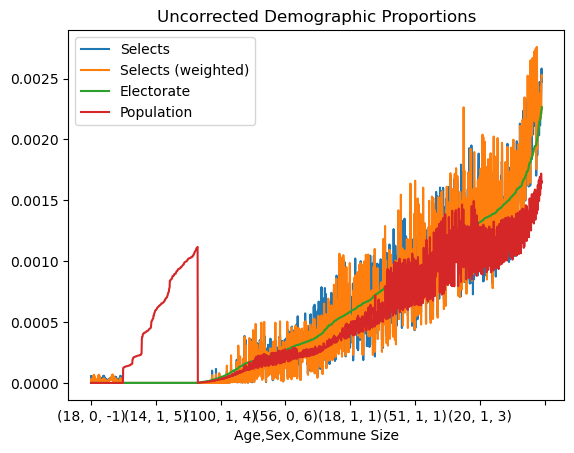

In [37]:
selects_demographics = age_smoothed_selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)['weightc'].sum().rename('Selects')
weighted_selects_demographics = age_smoothed_selects_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, COMMUNE_SIZE_ATTR]
)['weighttot'].sum().rename('Selects (weighted)')

electorate_demographics = electorate_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, electorate_year_df[COMMUNE_ATTR].map(postal_code_to_commune_size).rename(COMMUNE_SIZE_ATTR)]
)[POPULATION_ATTR].sum().rename('Electorate')
population_demographics = population_year_df.groupby(
    [AGE_ATTR, SEX_ATTR, population_year_df[COMMUNE_ATTR].map(postal_code_to_commune_size).rename(COMMUNE_SIZE_ATTR)]
)[POPULATION_ATTR].sum().rename('Population')

demographic_proportions = merge_proportional(
    selects_demographics, weighted_selects_demographics,
    electorate_demographics, population_demographics
).fillna(0).sort_values(['Electorate', 'Population'])

demographic_proportions.plot(title='Uncorrected Demographic Proportions')
print('Uncorrected demographics TVD:')
print(calculate_tvd(demographic_proportions, 'Electorate'))

In [8]:
from data.attribute import COMMUNE_SIZE_UNKNOWN

missing_population_demographics = demographic_proportions[demographic_proportions['Population'] == 0]
missing_population_commune_size = missing_population_demographics.index.get_level_values(COMMUNE_SIZE_ATTR).unique()

# All demographics that only appear in the selects data have an unknown commune size
assert missing_population_commune_size == [COMMUNE_SIZE_UNKNOWN]
missing_population_commune_size

Index([-1], dtype='int64', name=Commune Size)

In [9]:
missing_selects_demographics = demographic_proportions[demographic_proportions['Selects'] == 0]
missing_selects_demographics_count = len(missing_selects_demographics)


def _show_missing_proportion(description: str, mask: pd.Series) -> None:
    electorate_proportion = (missing_selects_demographics[mask]['Electorate'].sum() /
                             demographic_proportions['Electorate'].sum())
    print(f'{description}: {mask.sum()}/{missing_selects_demographics_count} demographics '
          f'({100 * electorate_proportion:.2f}% of electorate)')


is_underage = missing_selects_demographics.index.get_level_values(AGE_ATTR) < 18
_show_missing_proportion('Underage', is_underage)

OVERAGE_THRESHOLD = 85
is_overage = missing_selects_demographics.index.get_level_values(AGE_ATTR) > OVERAGE_THRESHOLD
_show_missing_proportion(f'Over age of {OVERAGE_THRESHOLD}', is_overage)

# All missing selects demographics are either underage or very old
missing_selects_demographics = missing_selects_demographics[~is_underage & ~is_overage]
assert len(missing_selects_demographics) == 0

Underage: 288/312 demographics (0.00% of electorate)
Over age of 85: 24/312 demographics (0.03% of electorate)


Clean uncorrected demographics TVD:
Selects               0.106874
Selects (weighted)    0.112131
Population            0.068863
dtype: float64
Proportion of electorate with unacceptable multipliers:
Selects               0.014623
Selects (weighted)    0.016385
Population            0.000000
dtype: float64


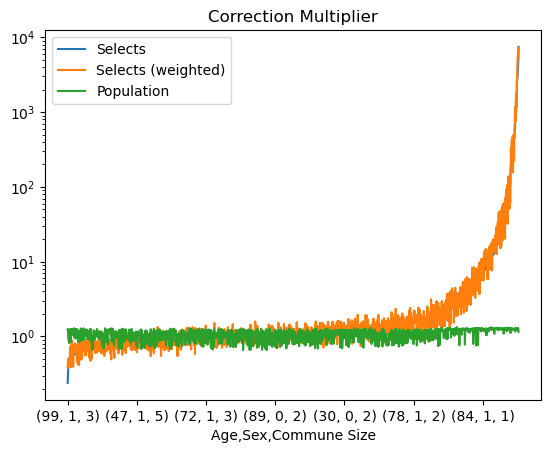

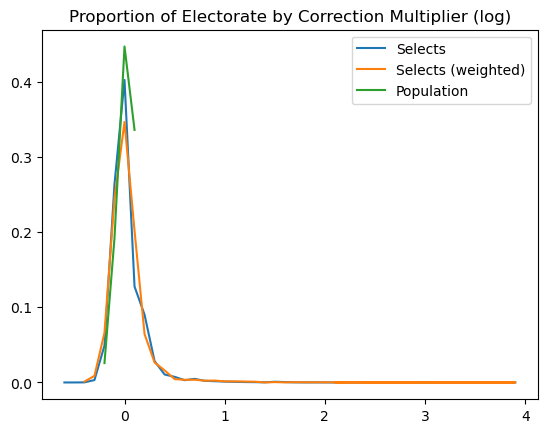

Corrected demographics TVD:
Population            0.0
Selects               0.0
Selects (weighted)    0.0
dtype: float64


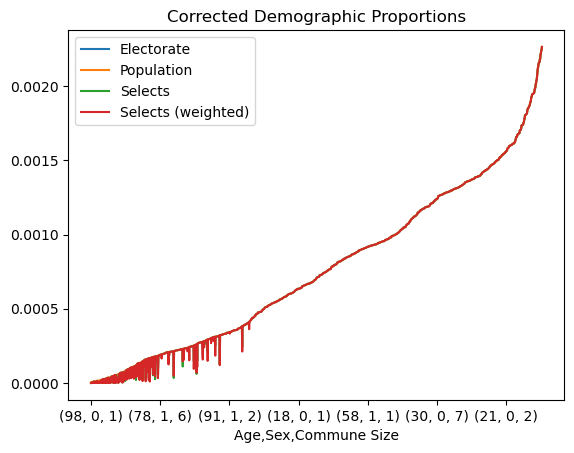

In [51]:
# Only use demographics present in both selects and population data
clean_demographic_proportions = demographic_proportions[
    (demographic_proportions['Selects'] > 0) & (demographic_proportions['Electorate'] > 0)
    ]
clean_demographic_proportions = clean_demographic_proportions.div(clean_demographic_proportions.sum(), axis=1)
print('Clean uncorrected demographics TVD:')
print(calculate_tvd(clean_demographic_proportions, 'Electorate'))

# Calculate required multiplier to correct selects' distribution
correction_multiplier = 1 / clean_demographic_proportions[['Selects', 'Selects (weighted)', 'Population']] \
    .div(clean_demographic_proportions['Electorate'], axis=0)
correction_multiplier.sort_values('Selects').plot(logy=True, title='Correction Multiplier')

# Check correction multiplier magnitude
multiplier_categories = np.round(np.log10(correction_multiplier), decimals=1)
multiplier_categories_proportion = pd.concat([
    clean_demographic_proportions['Electorate'].groupby(multiplier_categories[column]).sum().rename(column)
    for column in correction_multiplier.columns
], axis=1)
multiplier_categories_proportion.plot(title='Proportion of Electorate by Correction Multiplier (log)')

# Check for unacceptable multipliers
ACCEPTABLE_MULTIPLIER = 5
unacceptable_multiplier_proportion = multiplier_categories_proportion[
    np.log10(ACCEPTABLE_MULTIPLIER) < multiplier_categories_proportion.index
    ].sum()
print('Proportion of electorate with unacceptable multipliers:')
print(unacceptable_multiplier_proportion)
plt.show()

# Clip unacceptable multipliers
correction_multiplier = correction_multiplier.clip(upper=ACCEPTABLE_MULTIPLIER)
corrected_demographic_proportions = clean_demographic_proportions.multiply(correction_multiplier)
corrected_demographic_proportions.plot(title='Corrected Demographic Proportions')
print('Corrected demographics TVD:')
print(calculate_tvd(corrected_demographic_proportions, 'Electorate'))

# Apply demographic correction to unweighted selects
DEMOGRAPHIC_WEIGHT = 'weight_demographic'
corrected_age_smoothed_selects_year_df = age_smoothed_selects_year_df.copy()
corrected_age_smoothed_selects_year_df[DEMOGRAPHIC_WEIGHT] = 0.0
for (age, sex, commune_size), factor in correction_multiplier['Selects'].items():
    mask = ((corrected_age_smoothed_selects_year_df[AGE_ATTR] == age) &
            (corrected_age_smoothed_selects_year_df[SEX_ATTR] == sex) &
            (corrected_age_smoothed_selects_year_df[COMMUNE_SIZE_ATTR] == commune_size))
    corrected_age_smoothed_selects_year_df.loc[mask, DEMOGRAPHIC_WEIGHT] = factor
for col in ('weightc', 'weightst', 'weightp', 'weighttot'):
    corrected_age_smoothed_selects_year_df[col] *= corrected_age_smoothed_selects_year_df[DEMOGRAPHIC_WEIGHT]

Age distribution TVD:
Selects                0.067572
Selects (weighted)     0.057510
Selects (corrected)    0.005231
Population             0.091028
dtype: float64


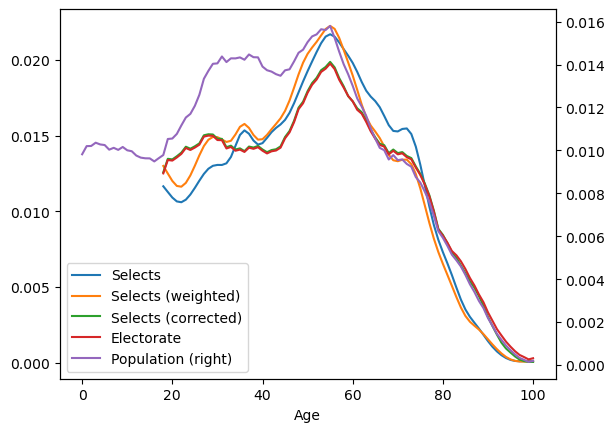

In [52]:
selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Selects')
weighted_selects_age = age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum().rename('Selects (weighted)')
corrected_selects_age = corrected_age_smoothed_selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum().rename('Selects (corrected)')

electorate_age = electorate_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_age = population_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Population')

merge_proportional(
    selects_age, weighted_selects_age, corrected_selects_age, electorate_age, population_age
).sort_index().plot(secondary_y='Population')

# Calculate Total Variation Distance from electorate for all distributions
age_distribution = merge_proportional(selects_age, weighted_selects_age, corrected_selects_age, electorate_age,
                                      population_age)
print('Age distribution TVD:')
print(calculate_tvd(age_distribution, 'Electorate'))

Sex distribution TVD:
Selects                0.019075
Selects (weighted)     0.002822
Selects (corrected)    0.001553
Population             0.017132
dtype: float64


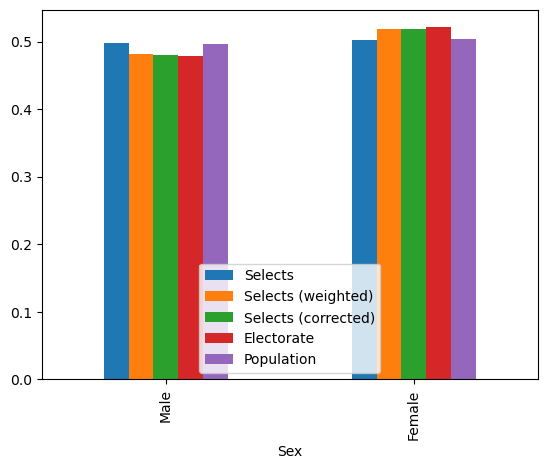

In [54]:
selects_sex = age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects')
weighted_selects_sex = age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weighttot'].sum() \
    .rename('Selects (weighted)')
corrected_selects_sex = corrected_age_smoothed_selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects (corrected)')
electorate_sex = electorate_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Electorate')
population_sex = population_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Population')

sex_distribution = merge_proportional(
    selects_sex, weighted_selects_sex, corrected_selects_sex, electorate_sex, population_sex
).rename(SEX_LABEL_MAPPER)
sex_distribution.plot(kind='bar')
print('Sex distribution TVD:')
print(calculate_tvd(sex_distribution, 'Electorate'))

Commune size distribution TVD:
Selects                0.015482
Selects (weighted)     0.024464
Selects (corrected)    0.002710
Population             0.032806
dtype: float64


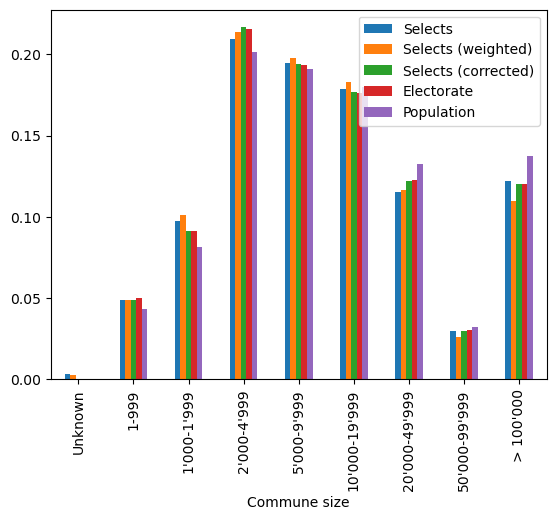

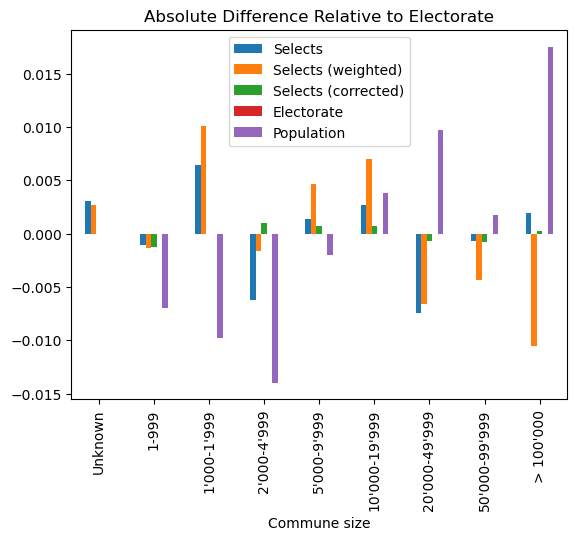

In [55]:
selects_commune_size = selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weightc'].sum().rename('Selects')
weighted_selects_commune_size = selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weighttot'].sum().rename('Selects (weighted)')
corrected_selects_commune_size = corrected_age_smoothed_selects_year_df.groupby(COMMUNE_SIZE_ATTR) \
    ['weightc'].sum().rename('Selects (corrected)')

electorate_commune_size = electorate_year_df.groupby(
    electorate_year_df[COMMUNE_ATTR].map(postal_code_to_commune_size)
)[POPULATION_ATTR].sum().rename('Electorate')
population_commune_size = population_year_df.groupby(
    population_year_df[COMMUNE_ATTR].map(postal_code_to_commune_size)
)[POPULATION_ATTR].sum().rename('Population')

commune_size_distribution = merge_proportional(
    selects_commune_size, weighted_selects_commune_size, corrected_selects_commune_size,
    electorate_commune_size, population_commune_size
).fillna(0)

commune_size_distribution.rename(COMMUNE_SIZE_LABEL_MAPPER).plot(kind='bar', xlabel='Commune size')
(commune_size_distribution.sub(commune_size_distribution['Electorate'], axis=0)).rename(COMMUNE_SIZE_LABEL_MAPPER).plot(
    kind='bar', xlabel='Commune size', title='Absolute Difference Relative to Electorate')
print('Commune size distribution TVD:')
print(calculate_tvd(commune_size_distribution, 'Electorate'))